In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import cftime
import duckdb

# Set the path to the NetCDF file
netcdf_file = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/hw95_summary/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.hwdaysOnly.nc'

# Set the output directory
output_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/hw95_summary'

summary_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/summary'


In [2]:


# Open the NetCDF file
ds = xr.open_dataset(netcdf_file)

# Select the variables we want to include
variables = ['TSA', 'TSA_U', 'TSA_R', 'TREFMXAV_R', 'HW']
ds_subset = ds[variables]

# Convert to DataFrame
df = ds_subset.to_dataframe().reset_index()

# Drop rows where TSA_U is missing
df = df.dropna(subset=['TSA_U'])

# Drop rows where TREFMXAV_R
df = df.dropna(subset=['TREFMXAV_R']) # this will remove 19850101 data

# Convert cftime to pandas datetime
def convert_cftime_to_datetime(ct):
    return pd.Timestamp(ct.year, ct.month, ct.day)

df['time'] = df['time'].apply(convert_cftime_to_datetime)

# Convert HW column to boolean
df['HW'] = df['HW'].notna() & (df['HW'] != 0)


loc_id_path = os.path.join(summary_dir, 'location_IDs.nc')
location_ds = xr.open_dataset(loc_id_path)
location_df = location_ds.to_dataframe().reset_index()

# Merge the location_df with the local_hour_adjusted_df
df = pd.merge(df, location_df, on=['lat', 'lon'], how='left')

# Sort the DataFrame
df = df.sort_values(['location_ID', 'time'])

# Save the DataFrame as a feather file
output_file = os.path.join(output_dir, 'hw_data.feather')
df.to_feather(output_file)

print(f"Data has been saved to {output_file}")

# Print some information about the resulting DataFrame
print("\nDataFrame Info:")
print(df.info())

print("\nFirst few rows of the DataFrame:")
print(df.head())

# Print unique lat-lon pairs
unique_locations = df[['lat', 'lon']].drop_duplicates()
print(f"\nNumber of unique lat-lon pairs: {len(unique_locations)}")



Data has been saved to /Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/hw95_summary/hw_data.feather

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 46417050 entries, 0 to 46417049
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   time         datetime64[ns]
 1   lat          float32       
 2   lon          float32       
 3   TSA          float32       
 4   TSA_U        float32       
 5   TSA_R        float32       
 6   TREFMXAV_R   float32       
 7   HW           bool          
 8   location_ID  int64         
dtypes: bool(1), datetime64[ns](1), float32(6), int64(1)
memory usage: 2.1 GB
None

First few rows of the DataFrame:
            time       lat     lon         TSA       TSA_U       TSA_R  \
0     1985-01-02 -55.13089  291.25  283.080292  283.184296  283.145355   
4239  1985-01-03 -55.13089  291.25  286.014801  286.173462  286.077148   
8478  1985-01-04 -55.13089  291.25  284.63113

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46417050 entries, 0 to 46417049
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   time         datetime64[ns]
 1   lat          float32       
 2   lon          float32       
 3   TSA          float32       
 4   TSA_U        float32       
 5   TSA_R        float32       
 6   TREFMXAV_R   float32       
 7   HW           bool          
 8   location_ID  int64         
dtypes: bool(1), datetime64[ns](1), float32(6), int64(1)
memory usage: 2.1 GB


In [4]:
# Count unique lat-lon pairs where HW = 1
hw_locations = df[df['HW'] == 1][['lat', 'lon']].drop_duplicates()
hw_location_count = len(hw_locations)

print(f"Number of unique lat-lon pairs with HW = 1: {hw_location_count}")

Number of unique lat-lon pairs with HW = 1: 3787


In [5]:
# import pandas as pd

# result = t_nan_dates.groupby('location_ID').filter(lambda x: len(x) == 1).groupby('location_ID').agg(
#     first_time=('time', 'first'),
#     count=('time', 'size')
# )

# result = result[result['first_time'] > '1985-01-01']
# print(result)

NameError: name 't_nan_dates' is not defined

In [ ]:


nan_dates = duckdb.query(
    """
    PRAGMA threads=4;
    SELECT location_ID, COUNT(*) AS count, min(time) 
    FROM df 
    Where time > '1985-01-01' --and TREFMXAV_R is NULL 
    GROUP BY location_ID  
    having count > 1
    """
).to_df()

In [7]:
duckdb.query(
    """
    SELECT  *
    FROM df
    where HW is not True 
    limit 10;
    """
).to_df()


,time,lat,lon,TSA,TSA_U,TSA_R,TREFMXAV_R,HW,location_ID
0,1985-01-02,-55.13089,291.25,283.080292,283.184296,283.145355,287.612152,False,10889
1,1985-01-03,-55.13089,291.25,286.014801,286.173462,286.077148,290.769989,False,10889
2,1985-01-04,-55.13089,291.25,284.631134,284.665680,284.676514,289.661041,False,10889
3,1985-01-05,-55.13089,291.25,282.343384,282.454590,282.399506,285.848999,False,10889
4,1985-01-06,-55.13089,291.25,283.974731,284.347656,284.043304,288.921173,False,10889
5,1985-01-07,-55.13089,291.25,282.339569,282.424072,282.394745,285.342987,False,10889
6,1985-01-08,-55.13089,291.25,282.139313,282.242035,282.198792,287.616028,False,10889
7,1985-01-09,-55.13089,291.25,281.322937,281.494507,281.386169,285.243835,False,10889
8,1985-01-10,-55.13089,291.25,278.200104,278.222321,278.254517,281.142944,False,10889
9,1985-01-11,-55.13089,291.25,279.001678,279.079620,279.064392,282.155914,False,10889


In [ ]:
# Calculate the ratio of HW occurrences
duckdb.query(
    """
    SELECT SUM(CAST(HW AS FLOAT)) / COUNT(*) AS HW_ratio
    FROM df;
    """
).to_df()


# define hw days and put in HW95 column

In [6]:
import pandas as pd
import numpy as np

# Sort the dataframe by location_ID and time
df_daily_tmax = df.sort_values(['location_ID', 'time'])

# Calculate the 95th percentile of TREFMXAV_R for each location_ID
threshold = df_daily_tmax.groupby('location_ID')['TREFMXAV_R'].transform(lambda x: x.quantile(0.95))

# Create a boolean mask for days exceeding the threshold
exceed_threshold = df_daily_tmax['TREFMXAV_R'] > threshold

# Use rolling window to identify streaks of 3 or more days
rolling_sum = exceed_threshold.groupby(df_daily_tmax['location_ID']).rolling(window=3, min_periods=3).sum()

# Reset index to align with original dataframe
rolling_sum = rolling_sum.reset_index(level=0, drop=True)

# Create HW95 column
df_daily_tmax['HW95'] = (rolling_sum >= 3) & exceed_threshold

# Fill NaN values with False (for the first two days of each location that can't be part of a 3-day streak)
df_daily_tmax['HW95'] = df_daily_tmax['HW95'].fillna(False)

In [10]:
hw_count = duckdb.query(
    """
    SELECT location_ID, COUNT(*) AS count
    FROM df_daily_tmax
    where HW95 = True
    group by location_ID
    order by count desc
    """
).to_df()


(array([  8.,  11.,  14.,  24.,  24.,  35.,  37.,  30.,  38.,  25.,  46.,
         45.,  42.,  52.,  47.,  47.,  52.,  40.,  43.,  42.,  56.,  54.,
         68.,  60.,  68.,  76.,  61., 106.,  90.,  93., 118.,  89., 133.,
        103.,  99.,  97.,  79., 135., 132.,  79., 114.,  76., 111.,  98.,
        134., 101.,  92.,  97.,  89., 114., 104.,  84.,  88.,  66.,  69.,
         57.,  30.,  34.,  30.,  26.,  22.,  27.,  22.,   3.,  11.,   8.,
          6.,   3.,   8.,   3.,   2.,   1.,   0.,   1.,   0.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  5.  ,   9.59,  14.18,  18.77,  23.36,  27.95,  32.54,  37.13,
         41.72,  46.31,  50.9 ,  55.49,  60.08,  64.67,  69.26,  73.85,
         78.44,  83.03,  87.62,  92.21,  96.8 , 101.39, 105.98, 110.57,
        115.16, 119.75, 124.34, 128.93, 133.52, 138.11, 142.7 , 147.29,
        151.88, 156.47, 161.06

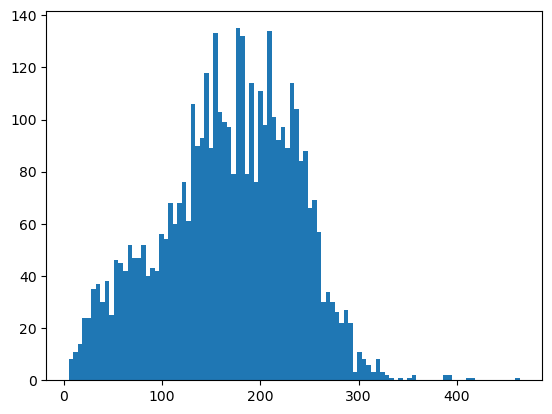

In [11]:
#histogram of hw_count.count
import matplotlib.pyplot as plt
plt.hist(hw_count['count'], bins=100)

In [16]:
# in df_daily_max, pct of rows that HW95 is True
# hw_pct = df_daily_tmax['HW95'].sum() / len(df_daily_tmax)
hw_pct = df_daily_tmax['HW95'].sum() 
print(f"Percentage of days with HW95: {hw_pct:.2%}")

Percentage of days with HW95: 71049400.00%


# HW90

In [23]:
import pandas as pd
import numpy as np
df_daily_tmax.drop(columns=['HW90'], inplace=True)

# Sort the dataframe by location_ID and time
df_daily_tmax = df_daily_tmax.sort_values(['location_ID', 'time'])

# Calculate the 95th percentile of TREFMXAV_R for each location_ID
threshold = df_daily_tmax.groupby('location_ID')['TREFMXAV_R'].transform(lambda x: x.quantile(0.90))

# Create a boolean mask for days exceeding the threshold
exceed_threshold = df_daily_tmax['TREFMXAV_R'] > threshold

# Use rolling window to identify streaks of 3 or more days
rolling_sum = exceed_threshold.groupby(df_daily_tmax['location_ID']).rolling(window=3, min_periods=3).sum()

# Reset index to align with original dataframe
rolling_sum = rolling_sum.reset_index(level=0, drop=True)

# Create HW95 column
df_daily_tmax['HW90'] = (rolling_sum >= 3) & exceed_threshold

# Fill NaN values with False (for the first two days of each location that can't be part of a 3-day streak)
df_daily_tmax['HW90'] = df_daily_tmax['HW90'].fillna(False)

In [30]:
# in df_daily_max, pct of rows that HW95 is True
hw_pct = df_daily_tmax['HW'].sum() / len(df_daily_tmax)
print(f"Percentage of days with HW95: {hw_pct:.2%}")

Percentage of days with HW95: 100.00%


In [27]:
df_daily_tmax['threshold95'] = df_daily_tmax.groupby('location_ID')['TREFMXAV_R'].transform(lambda x: x.quantile(0.95))
df_daily_tmax['threshold90'] = df_daily_tmax.groupby('location_ID')['TREFMXAV_R'].transform(lambda x: x.quantile(0.90))

In [29]:
duckdb.query(
    """
    SELECT *
    FROM df_daily_tmax
    where HW != HW90
    """
).to_df()

,time,lat,lon,TSA,TSA_U,TSA_R,TREFMXAV_R,HW,location_ID,HW95,threshold95,threshold90,HW90
0,1985-01-02,-55.130890,291.25,283.080292,283.184296,283.145355,287.612152,True,10889,False,288.305748,286.947717,False
1,1985-01-03,-55.130890,291.25,286.014801,286.173462,286.077148,290.769989,True,10889,False,288.305748,286.947717,False
2,1985-01-05,-55.130890,291.25,282.343384,282.454590,282.399506,285.848999,True,10889,False,288.305748,286.947717,False
3,1985-01-06,-55.130890,291.25,283.974731,284.347656,284.043304,288.921173,True,10889,False,288.305748,286.947717,False
4,1985-01-07,-55.130890,291.25,282.339569,282.424072,282.394745,285.342987,True,10889,False,288.305748,286.947717,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44482165,2014-12-28,70.209427,31.25,265.840302,267.010468,265.837311,268.386871,True,48985,False,291.153134,288.612503,False
44482166,2014-12-29,70.209427,31.25,260.736969,261.607880,260.734741,267.643524,True,48985,False,291.153134,288.612503,False
44482167,2014-12-30,70.209427,31.25,259.080231,259.440735,259.079315,263.508362,True,48985,False,291.153134,288.612503,False
44482168,2014-12-31,70.209427,31.25,265.501678,265.772552,265.500977,274.362762,True,48985,False,291.153134,288.612503,False


In [32]:
duckdb.query(
    """
    SELECT location_ID, COUNT(*) AS count
    FROM df_daily_tmax
    group by location_ID
    """
).to_df()

,location_ID,count
0,25366,10950
1,30840,10950
2,40330,10950
3,28537,10950
4,28591,10950
...,...,...
4234,34048,10950
4235,39222,10950
4236,41203,10950
4237,41205,10950


In [33]:
10950/365

30.0

In [13]:
!ls -ltrh {output_file}

-rw-rw-r-- 1 jguo jguo 1.3G Jul  4 13:07 /Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/hw95_summary/hw_data.feather


In [14]:
df = pd.read_feather(output_file)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46417050 entries, 0 to 46417049
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   time         datetime64[ns]
 1   lat          float32       
 2   lon          float32       
 3   TSA          float32       
 4   TSA_U        float32       
 5   TSA_R        float32       
 6   TREFMXAV_R   float32       
 7   HW           bool          
 8   location_ID  int64         
 9   HW95         bool          
 10  threshold95  float64       
 11  HW90         bool          
 12  threshold90  float64       
dtypes: bool(3), datetime64[ns](1), float32(6), float64(2), int64(1)
memory usage: 2.9 GB
